---
title: "Application of R for Finance - Assignment 2"
subtitle: "Stocks Return Analysis and Fama-French 3 Model"
author: Group 30 
date: "17 October 2025"
institute: "Imperial Business School"
format:
  pdf:
    fig-cap-location: top
    include-in-header:
      text: |
        \usepackage[labelfont=bf,textfont=bf]{caption}   
execute:
  warning: false
  message: false
---
\newpage
\tableofcontents
\listoffigures
\newpage

# **Data Preparation**

## Required libraries
Load the following libraries for data analysis and visualisation.


In [27]:
library(dplyr)
library(lubridate)
library(ggplot2)

## Data Frame

Load the dataset **sp500_2023_2024.csv** into a data frame.

This dataset contains company identifiers, trading information, and classification codes. List below summarises the main variables.

In [28]:
# load the data
data <- read.csv("sp500_2023_2024.csv")

In [29]:
# remove any rows with NA values in the prcod column
data <- data %>%
  filter(!is.na(prcod))

In [30]:
# inspect the strucutre
head(data)

,tic,datadate,conm,exchg,sic,cshtrd,prccd,prchd,prcld,prcod,gvkey
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,PNW,03/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,1442534,74.63,76.4125,73.380,76.25,1075
2,PNW,04/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,954218,75.39,76.0950,74.630,75.10,1075
3,PNW,05/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,994775,73.65,75.0950,73.305,74.88,1075
4,PNW,06/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,729808,75.46,76.0200,74.480,74.49,1075
5,PNW,09/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,656127,75.55,76.4800,75.240,75.24,1075
6,PNW,10/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,763254,75.65,75.6950,74.880,75.31,1075


# **Part I - Q&A**

In the first section, we interrogate the data following the Assignment Specification.


### Q1 - Unique tickers

In [31]:
# indentify the amount of unique tickers
length(unique(data$tic))
print(paste("There are", length(unique(data$tic)), "unique tickers"))

[1] 502

[1] "There are 502 unique tickers"


### Q2 - Unique companies


In [32]:
# indentify the amount of unique companies
length(unique(data$conm))
print(paste("There are", length(unique(data$conm)), "unique companies"))

[1] 499

[1] "There are 499 unique companies"


### Q3 - Top 5 Mean Trading Volume Companies

In [33]:
# indentify the top 5 companies by largest mean trading volume
top_5_volume <- data %>%
  group_by(conm) %>%
  summarize(mean_volume = mean(cshtrd, na.rm = TRUE)) %>%
  arrange(desc(mean_volume)) %>%
  slice_head(n = 5)

# display in a table
top_5_volume

conm,mean_volume
<chr>,<dbl>
TESLA INC,115314383
NVIDIA CORP,113131835
PALANTIR TECHNOLOG INC,60056251
APPLE INC,57736403
ADVANCED MICRO DEVICES,57143415


### Q4 - Top 3 Total Trading Volume Exchanges

In [34]:
# indentify the top 3 exchanges by total largest total trading volume
top_3_exchanges <- data %>%
  group_by(exchg) %>%
  summarize(total_volume = sum(cshtrd, na.rm = TRUE)) %>%
  arrange(desc(total_volume)) %>%
  slice_head(n = 3)

# display in a table
top_3_exchanges

exchg,total_volume
<int>,<dbl>
11,681415756062
14,570830885382
21,385399362


### Q5 - Visualisation of Top 3 Total Trading Volume Exchanges

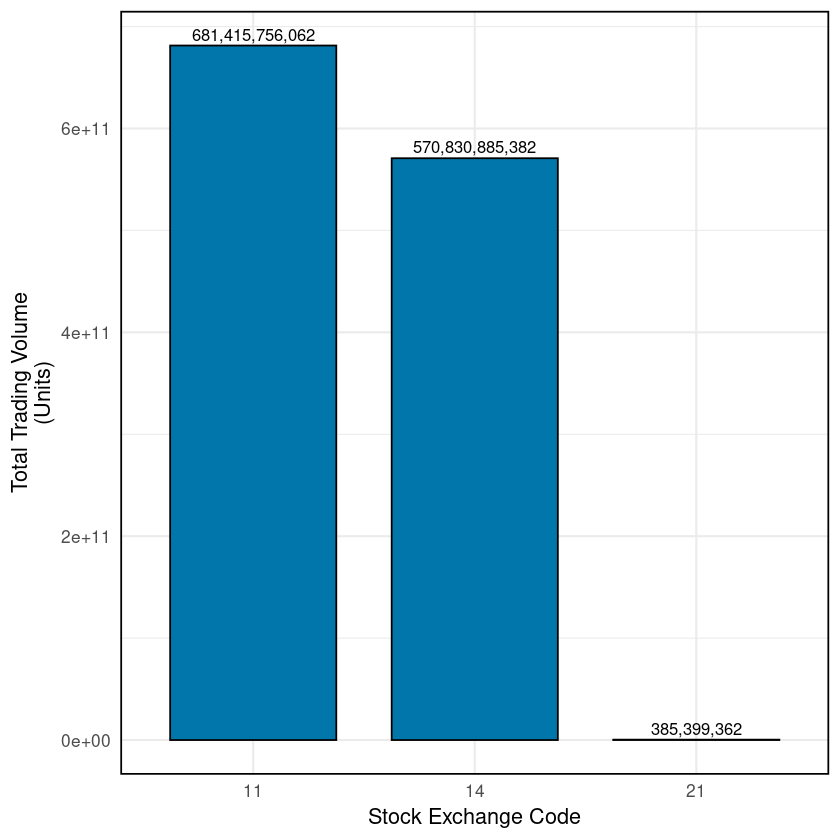

In [35]:
#| fig-cap: "Top 3 Exchanges by Total Trading Volume"
# display in a bar plot
ggplot(top_3_exchanges, aes(x = as.factor(exchg), y = total_volume)) +
  geom_col(width = 0.75, fill = "#0076AA", color = "black") +
  geom_text(aes(label = scales::comma(total_volume)), vjust = -0.4, size = 3.5) +
  labs(x = "Stock Exchange Code", y = "Total Trading Volume\n(Units)") +
  theme_minimal(base_size = 13) +
  theme(panel.border = element_rect(color = "black", fill = NA, size = 1))

### Q6 - Companies with More Than One Ticker

In [36]:
# indentify companies have more than one ticker
ticker_counts <- data %>%
  group_by(conm) %>%
  summarize(ticker_count = n_distinct(tic)) %>%
  filter(ticker_count > 1)

# display the result
ticker_counts

conm,ticker_count
<chr>,<int>
ALPHABET INC,2
FOX CORP,2
NEWS CORP,2


### Q7 - Ticker with the Largest Positive Mean Return

In [37]:
# indentify the ticker with the largest positive mean return (simple daily return)
mean_returns <- data %>%
  group_by(tic) %>%
  mutate(ret = (prccd - lag(prccd)) / lag(prccd)) %>%
  summarize(mean_return = mean(ret, na.rm = TRUE)) %>%
  arrange(desc(mean_return)) %>%
  slice_head(n = 1)

# display the resuly
mean_returns

tic,mean_return
<chr>,<dbl>
PLTR,0.005785119


### Q8 - Company with the Largest Positive Mean Return

In [38]:
# indentify the company with the largest positive mean return (simple daily return)
mean_returns_company <- data %>%
  group_by(conm) %>%
  mutate(ret = (prccd - lag(prccd)) / lag(prccd)) %>%
  summarize(mean_return = mean(ret, na.rm = TRUE)) %>%
  arrange(desc(mean_return)) %>%
  slice_head(n = 1)

# display the result
mean_returns_company

conm,mean_return
<chr>,<dbl>
PALANTIR TECHNOLOG INC,0.005785119


### Q9 - Industry Represented by the Most Companies

In [39]:
# indentify the industry is represented by the most companies
industry_counts <- data %>%
  group_by(sic) %>%
  summarize(company_count = n_distinct(conm)) %>%
  arrange(desc(company_count)) %>%
  slice_head(n = 1)

# display the result
industry_counts

sic,company_count
<int>,<int>
6798,28


# **Part II - Extended Analysis**

In the second section, we first calculate the weekly returns with following formulas to carry out the extended analysis. After categorising the data into decile groups, a specific security is picked for further analysis.

$$
R_{\text{weekly}} = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

where:

- $R_{\mathrm{weekly}}$ = Simple weekly return  
- $P_t$ = Closing price at the end of the current week  
- $P_{t-1}$ = Closing price at the end of the previous week

### Q1 - Weekly Returns

In [40]:
# calculate the simple weekly returns
weekly_returns <- data %>%
  mutate(datadate = as.Date(datadate, format = "%d/%m/%Y")) %>%
  group_by(tic) %>%
  arrange(datadate) %>%
  mutate(Week = floor_date(datadate, unit = "week")) %>%
  group_by(tic, Week) %>%
  summarise(Weekly_Close = last(prccd)) %>%
  arrange(tic, Week) %>%
  mutate(Weekly_Return = (Weekly_Close / lag(Weekly_Close)) - 1) %>%
  ungroup()

`summarise()` has grouped output by 'tic'. You can override using the `.groups`
argument.


### Q2 - Decile Classification

In [41]:
# categorise data into decile groups, labelled 0%, 10%, 20%, ...
quantile_result <- weekly_returns %>%
  mutate(
    deciles = cut(
      Weekly_Return,
      breaks = quantile(
        Weekly_Return,
        probs = c(0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        type = 5,
        na.rm = TRUE
      ),
      include.lowest = TRUE,
      labels = c("0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%")
    )
  )

# display the result
head(quantile_result)

tic,Week,Weekly_Close,Weekly_Return,deciles
<chr>,<date>,<dbl>,<dbl>,<fct>
A,2023-01-01,147.67,NA,NA
A,2023-01-08,156.92,0.062639670,90%
A,2023-01-15,155.92,-0.006372674,30%
A,2023-01-22,155.69,-0.001475115,40%
A,2023-01-29,154.55,-0.007322243,30%
A,2023-02-05,152.55,-0.012940796,30%


### Q3 - Top Ticker in each Decile Group

In [42]:
# identify the top ticker in each decile group
top_tickers <- quantile_result %>%
  group_by(deciles) %>%
  filter(Weekly_Return == max(Weekly_Return)) %>%
  select(deciles, tic, Weekly_Return) %>%
  arrange(deciles)
  
# display the result in a table
top_tickers

deciles,tic,Weekly_Return
<fct>,<chr>,<dbl>
0%,DVN,-0.041509434
10%,FDS,-0.024781950
20%,CNC,-0.014084507
20%,TRMB,-0.014084507
30%,NWS,-0.005443235
40%,CDNS,0.002281542
50%,AIG,0.010124311
60%,HLT,0.018477517
70%,RL,0.029158383


### Q4 - Ticker Selection from 60% Decile Group

Here, we select the **top ticker** from 60% decile group for the following analysis.

In [43]:
# display the top ticker in 60% decile group
top_60_ticker <- top_tickers %>%
  filter(deciles == "60%")
print(top_60_ticker$tic)

[1] "HLT"


### Q5 - Autocorrelation Anlysis

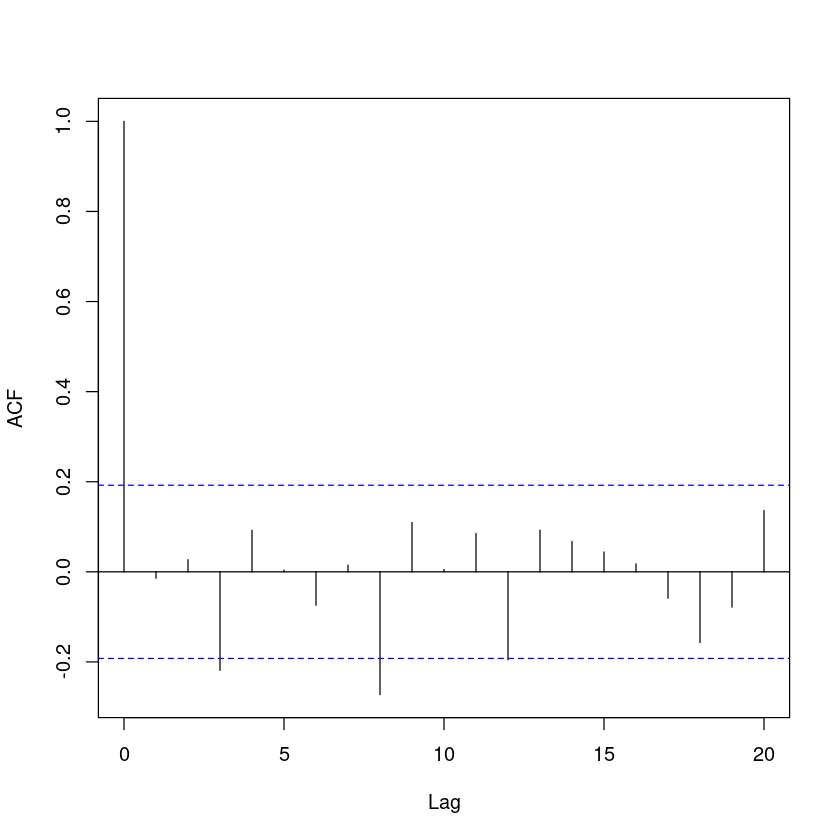

In [50]:
#| fig-cap: "Autocorrelation HLT Weekly Returns"
# plot the autocorrelation function for HLT's entire set of weekly returns
wdc_data <- weekly_returns %>%
  filter(tic == "HLT") %>%
  na.omit()

# Autocorrelate
acf(wdc_data$Weekly_Return, main="")

# **Part III - Fama-French 3 Factor Model**

In the last section, we first load and clean the the **fama_french_weekly.csv** to provide the weekly Fama-French 3 factors for modelling. Next, the selected ticker **HLT** is fitted the Fama-French 3 factor model.

In [51]:
# load and clean the data
fama_french_data <- read.csv("fama_french_weekly.csv", skip=4)
fama_french_data$datadate <- as.Date(as.character(fama_french_data$X), format="%Y%m%d")
fama_french_data <- select(fama_french_data, datadate, Mkt.RF, SMB, HML, RF)

In [52]:
# for each column except datadate, divided by 100 to convert to decimal format
fama_french_data <- fama_french_data %>%
  mutate(across(-datadate, ~ . / 100)) 

fama_french_data %>%
    filter(datadate >= as.Date("2023-01-01")) %>%
    slice(1)
    
rearrange_wdc_data <- data %>%
  filter(tic == "HLT") %>%
  mutate(datadate = as.Date(datadate, format = "%d/%m/%Y")) %>%
  arrange(datadate)

# calculate the weekly returns for WDC and make sure the datadate is aligned with Fama-French data
rearrange_wdc_data <- rearrange_wdc_data %>%
  mutate(Week = floor_date(datadate, unit = "week", week_start = 5)) %>%
  group_by(Week) %>%
  summarise(Weekly_Close = last(prccd)) %>%
  arrange(Week) %>%
  mutate(Weekly_Return = (Weekly_Close / lag(Weekly_Close)) - 1) %>%
  na.omit()

# display the data
head(rearrange_wdc_data)

datadate,Mkt.RF,SMB,HML,RF
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-06,0.0137,0.0027,0.0125,9e-04


Week,Weekly_Close,Weekly_Return
<date>,<dbl>,<dbl>
2023-01-06,135.00,0.0643330180
2023-01-13,135.06,0.0004444444
2023-01-20,144.06,0.0666370502
2023-01-27,147.09,0.0210329030
2023-02-03,150.80,0.0252226528
2023-02-10,148.28,-0.0167108753


In [53]:
# merge the data
merged_data <- merge(rearrange_wdc_data, fama_french_data, by.x = "Week", by.y = "datadate") 

# display the merged data
head(merged_data)

,Week,Weekly_Close,Weekly_Return,Mkt.RF,SMB,HML,RF
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2023-01-06,135.00,0.0643330180,0.0137,0.0027,0.0125,9e-04
2,2023-01-13,135.06,0.0004444444,0.0302,0.0337,-0.0324,9e-04
3,2023-01-20,144.06,0.0666370502,-0.0069,0.0012,-0.0115,9e-04
4,2023-01-27,147.09,0.0210329030,0.0257,-0.0009,-0.0122,9e-04
5,2023-02-03,150.80,0.0252226528,0.0181,0.0354,-0.0199,9e-04
6,2023-02-10,148.28,-0.0167108753,-0.0149,-0.0320,0.0266,9e-04


In [54]:
# calculate excess returns
merged_data <- merged_data %>%
  mutate(Excess_Return = Weekly_Return - Mkt.RF)

In [55]:
# model fitting
model <- lm(Excess_Return ~ Mkt.RF + SMB + HML, data = merged_data)
summary(model)


Call:
lm(formula = Excess_Return ~ Mkt.RF + SMB + HML, data = merged_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.061769 -0.021092  0.001118  0.017433  0.063231 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.006137   0.002632   2.332   0.0217 *  
Mkt.RF      -0.760352   0.152090  -4.999 2.52e-06 ***
SMB         -0.123988   0.172396  -0.719   0.4737    
HML          0.080787   0.153443   0.526   0.5997    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02573 on 98 degrees of freedom
Multiple R-squared:  0.2763,	Adjusted R-squared:  0.2541 
F-statistic: 12.47 on 3 and 98 DF,  p-value: 5.642e-07


# **Analysis Report**

This report applied R-based analysis to stock returns and Fama-French 3 factor model.
